In [ ]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/kaggle/input/clicks-conversion-tracking/KAG_conversion_data.csv")

FileNotFoundError: FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/clicks-conversion-tracking/KAG_conversion_data.csv'

In [ ]:
original_data = pd.read_csv("/data/notebook_files/KAG_conversion_data.csv")
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   xyz_campaign_id      1143 non-null   int64  
 2   fb_campaign_id       1143 non-null   int64  
 3   age                  1143 non-null   object 
 4   gender               1143 non-null   object 
 5   interest             1143 non-null   int64  
 6   Impressions          1143 non-null   int64  
 7   Clicks               1143 non-null   int64  
 8   Spent                1143 non-null   float64
 9   Total_Conversion     1143 non-null   int64  
 10  Approved_Conversion  1143 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB


In [ ]:
# There are three unique campaign in the dataset.
camp_id_list = original_data["xyz_campaign_id"].unique()

# construct the campaign data
camp_data = {'xyz_campaign_id': [], 'Impressions': [], 'Clicks': [], 'Spent': [], 'Total_Conversion': [], 'Approved_Conversion': []}
for id in camp_id_list:
    camp_data['xyz_campaign_id'].append(id)
    camp_data['Impressions'].append(sum(original_data[original_data['xyz_campaign_id'] == id]['Impressions']))
    camp_data['Clicks'].append(sum(original_data[original_data['xyz_campaign_id'] == id]['Clicks']))
    camp_data['Spent'].append(sum(original_data[original_data['xyz_campaign_id'] == id]['Spent']))
    camp_data['Total_Conversion'].append(sum(original_data[original_data['xyz_campaign_id'] == id]['Total_Conversion']))
    camp_data['Approved_Conversion'].append(sum(original_data[original_data['xyz_campaign_id'] == id]['Approved_Conversion']))
    
camp_data = pd.DataFrame(camp_data)
print(camp_data)

   xyz_campaign_id  Impressions  Clicks         Spent  Total_Conversion  \
0              916       482925     113    149.710001                58   
1              936      8128187    1984   2893.369999               537   
2             1178    204823716   36068  55662.149959              2669   

   Approved_Conversion  
0                   24  
1                  183  
2                  872  


In [ ]:
camp_data.insert(6, "Spent/Imp(k)", camp_data['Spent']/camp_data['Impressions']*1000, True)
camp_data.insert(7, "Conversion/Imp(k)", camp_data['Total_Conversion']/camp_data['Impressions']*1000, True)
print(camp_data)

   xyz_campaign_id  Impressions  Clicks         Spent  Total_Conversion  \
0              916       482925     113    149.710001                58   
1              936      8128187    1984   2893.369999               537   
2             1178    204823716   36068  55662.149959              2669   

   Approved_Conversion  Spent/Imp(k)  Conversion/Imp(k)  
0                   24      0.310007           0.120101  
1                  183      0.355967           0.066066  
2                  872      0.271756           0.013031  


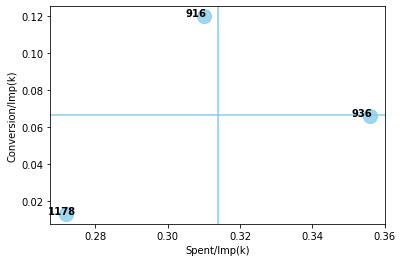

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
sns.regplot(x=camp_data["Spent/Imp(k)"], y=camp_data["Conversion/Imp(k)"],fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})

for line in range(0,camp_data.shape[0]):
     plt.text(camp_data["Spent/Imp(k)"][line]-0.005, camp_data["Conversion/Imp(k)"][line], camp_data["xyz_campaign_id"][line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.axvline(min(camp_data["Spent/Imp(k)"]) + (max(camp_data["Spent/Imp(k)"])-min(camp_data["Spent/Imp(k)"]))/2, color='skyblue')
plt.axhline(min(camp_data["Conversion/Imp(k)"]) + (max(camp_data["Conversion/Imp(k)"])-min(camp_data["Conversion/Imp(k)"]))/2, color='skyblue')
plt.show()

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader

camp_1178_data = original_data[original_data['xyz_campaign_id'] == 1178]
camp_1178_data.reset_index(drop = True, inplace = True)
camp_1178_data.drop(columns=['ad_id', 'xyz_campaign_id', 'fb_campaign_id', 'Clicks', 'Spent', "Approved_Conversion"], inplace = True)
camp_1178_data["Impressions"] = preprocessing.scale(camp_1178_data["Impressions"])
camp_1178_data["Total_Conversion"] = preprocessing.scale(camp_1178_data["Total_Conversion"])

age2index = dict([(y,x+1) for x,y in enumerate(sorted(set(camp_1178_data["age"])))])
gender2index = dict([(y,x+1) for x,y in enumerate(sorted(set(camp_1178_data["gender"])))])
interest2index = dict([(y,x+1) for x,y in enumerate(sorted(set(camp_1178_data["interest"])))])

camp_1178_data['age'] = camp_1178_data['age'].map(age2index)
camp_1178_data['gender'] = camp_1178_data['gender'].map(gender2index)
camp_1178_data['interest'] = camp_1178_data['interest'].map(interest2index)

X = camp_1178_data.iloc[:, :4]
y = camp_1178_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

class CustomCampaignDataset(Dataset):
    def __init__(self, target, results):
        self.target = target
        self.results = results
    
    def __len__(self):
        return len(self.results)
    
    def __getitem__(self, idx):
        target = self.target[idx]
        result = self.results[idx]
        return target, result

trainset = CustomCampaignDataset(torch.tensor(np.array(X_train)), torch.tensor(np.array(y_train)))
testset = CustomCampaignDataset(torch.tensor(np.array(X_test)), torch.tensor(np.array(y_test)))

train_dataloader = DataLoader(trainset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=4, shuffle=True)

In [ ]:
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
        )
        
    def forward(self, x):
        y = self.linear(x)
        return y

model = NeuralNetwork().to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y.float()).item()
    test_loss /= num_batches
    print(f"Test Error: \n, Avg loss: {test_loss:>8f} \n")

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
, Avg loss: 0.952174 

Epoch 2
-------------------------------
Test Error: 
, Avg loss: 0.930446 

Epoch 3
-------------------------------
Test Error: 
, Avg loss: 0.901495 

Epoch 4
-------------------------------
Test Error: 
, Avg loss: 0.890255 

Epoch 5
-------------------------------
Test Error: 
, Avg loss: 0.891847 

Done!


In [ ]:
import random

with torch.no_grad():
    impressions = [-0.5, 0, 0.5]
    for impression in impressions:
        simulate_data = {'age': [], 'gender': [], 'interest': [], 'Impressions': [], 'Total_Conversion': []}
        for i in age2index.keys():
            for j in gender2index.keys():
                for k in interest2index.keys():
                    simulate_data['age'].append(i)
                    simulate_data['gender'].append(j)
                    simulate_data['interest'].append(k)
                    simulate_data['Impressions'].append(impression)
                    simulate_data['Total_Conversion'].append(model(torch.tensor(np.array([age2index.get(i), gender2index.get(j), interest2index.get(k), impression])).float()))
        simulate_data = pd.DataFrame(simulate_data)
        print(simulate_data.sort_values(by=['Total_Conversion'], ascending=False).head())

       age gender  interest  Impressions   Total_Conversion
0    30-34      F         2         -0.5  [tensor(-0.1240)]
1    30-34      F         7         -0.5  [tensor(-0.1240)]
218  40-44      M        31         -0.5  [tensor(-0.1240)]
217  40-44      M        30         -0.5  [tensor(-0.1240)]
216  40-44      M        29         -0.5  [tensor(-0.1240)]
       age gender  interest  Impressions   Total_Conversion
0    30-34      F         2            0  [tensor(-0.1240)]
1    30-34      F         7            0  [tensor(-0.1240)]
218  40-44      M        31            0  [tensor(-0.1240)]
217  40-44      M        30            0  [tensor(-0.1240)]
216  40-44      M        29            0  [tensor(-0.1240)]
       age gender  interest  Impressions   Total_Conversion
0    30-34      F         2          0.5  [tensor(-0.1240)]
1    30-34      F         7          0.5  [tensor(-0.1240)]
218  40-44      M        31          0.5  [tensor(-0.1240)]
217  40-44      M        30          0.5